# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data

In [ ]:
mdv = pd.read_csv('boston.csv')
mdv.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Split data: train-validation-test


In [ ]:
from sklearn.model_selection import train_test_split

feature = mdv.drop(columns='medv')
target = mdv[['medv']]

feature_mdv_pretrain, feature_mdv_test, target_mdv_pretrain, target_mdv_test = train_test_split(feature, target, test_size=0.20, random_state=42)

feature_mdv_train, feature_mdv_validation, target_mdv_train, target_mdv_validation = train_test_split(feature_mdv_pretrain, target_mdv_pretrain, test_size=0.20, random_state=42)

## Check Multicollinearity

In [ ]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_mdv_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


There are several features with moderate multicollinearity (VIP Score between 4 & 10):
1. `nox`
2. `dis`
3. `rad`
4. `tax`

There is multicollinearity in the data we have. It can cause a harmful impact. That is, the coefficient on the training data can become unstable

## Corellation Heatmap
We can continue by doing a correlation heatmap analysis to find out which features need to be dropped.


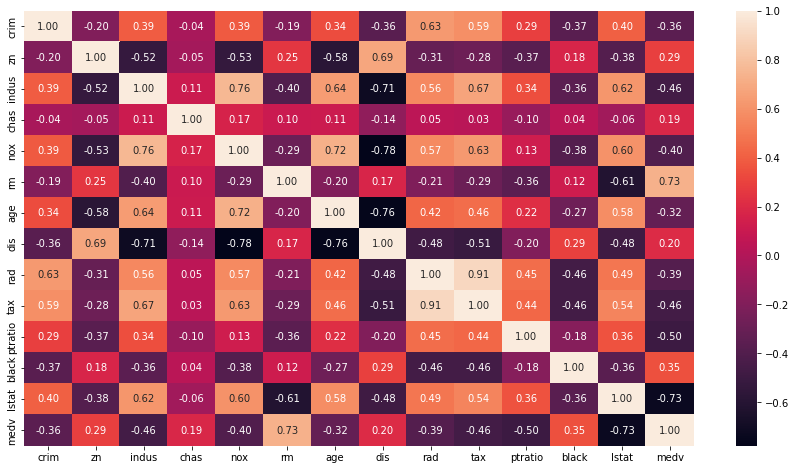

In [ ]:
mdv_train = pd.concat([feature_mdv_train, target_mdv_train], axis=1)
corr = mdv_train.corr()

plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

## Drop Multicollinear Features

In [ ]:
feature_mdv_train = feature_mdv_train.drop(columns=['rad'])
feature_mdv_validation = feature_mdv_validation.drop(columns=['rad'])
feature_mdv_test = feature_mdv_test.drop(columns=['rad'])

## Recheck VIP

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_mdv_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,crim,1.615076
2,zn,2.415036
3,indus,3.500250
4,chas,1.097962
5,nox,4.552308
6,rm,1.923266
7,age,3.119817
8,dis,4.390362
9,tax,3.191363
10,ptratio,1.804558


## Train Multiple Models with Ridge
with different alpha (lambda)

In [ ]:
from sklearn.linear_model import Ridge

# train the model
X_mdv_train = feature_mdv_train.to_numpy()
y_mdv_train = target_mdv_train.to_numpy()
y_mdv_train = y_mdv_train.reshape(len(y_mdv_train),)

# define the model
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_mdv_train, y_mdv_train)
ridge_reg_pointone.fit(X_mdv_train, y_mdv_train)
ridge_reg_one.fit(X_mdv_train, y_mdv_train)
ridge_reg_ten.fit(X_mdv_train, y_mdv_train)

Ridge(alpha=10, random_state=42)

## Find the best model (alpha)
Based on validation set

In [ ]:
from sklearn.metrics import mean_squared_error

X_mdv_validation = feature_mdv_validation.to_numpy()
y_mdv_validation = target_mdv_validation.to_numpy()
y_mdv_validation = y_mdv_validation.reshape(len(y_mdv_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_mdv_validation)
    rmse = np.sqrt(mean_squared_error(y_mdv_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 4.960676932957843
RMSE of Ridge regression model with alpha = 0.1 is 4.949412535122791
RMSE of Ridge regression model with alpha = 1.0 is 4.912351371579991
RMSE of Ridge regression model with alpha = 10 is 4.871717983886228


Note : alpha = 10 is the best for modelling

## Model Evaluation

In [ ]:
ridge_best = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_mdv_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,15.064666
1,crim,-0.071408
2,zn,0.033030
3,indus,-0.067858
4,chas,1.955801
5,nox,-1.568248
6,rm,4.783168
7,age,-0.011523
8,dis,-1.260056
9,tax,-0.001976


Note: From the evaluation model, we can see that `rm` (Number rooms average) has the highest coefficient value. Which means that every 1 point addition to `rm` by assuming the other variables are constant is associated with an increase of 4.783168 in Medv (the median value of owner-occupied homes in $1000's)

## Diagnostic Study

In [ ]:
from sklearn.metrics import r2_score

y_predict_train = ridge_best.predict(X_mdv_train)

print('R-squared for training data is {}'.format(r2_score(y_mdv_train, y_predict_train)))

R-squared for training data is 0.748587526366982


Note : R2 score = 0.7485, indicating 74.85% of the variability of the target can be explained by the features that exist in the model (it's good)

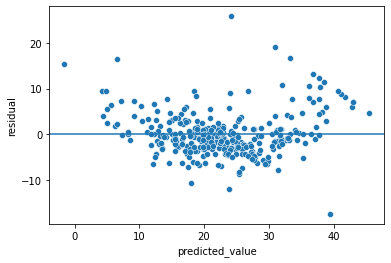

In [ ]:
# calculate residuals
residual = y_mdv_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

### Assumptions checked:
1. Linearity assumption validated
2. Residual didn't have a constant variance
3. Independent Residual

## Training Error

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_mdv_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_mdv_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_mdv_train, y_predict_train)))

RMSE for training data is 4.778640361040111
MAE for training data is 3.3776762058865626
MAPE for training data is 0.16868073663359498


### Testing Error

In [ ]:
# prepare prediction result on test data
X_mdv_test = feature_mdv_test.to_numpy()
y_predict_test = ridge_best.predict(X_mdv_test)

# ground truth target
y_mdv_test = target_mdv_test.to_numpy()
y_mdv_test = y_mdv_test.reshape(len(y_mdv_test),)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_mdv_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_mdv_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_mdv_test, y_predict_test)))

RMSE for testing data is 5.158908333657057
MAE for testing data is 3.2444816457044965
MAPE for testing data is 0.17618402626767926


Note : MAPE on Training Error = 0.1686 (16,86%) and MAPE on Testing Error = 0.17618 (17,62%); it shows that the model is just right, not overfitting or underfitting

## Train Multiple Models with Lasso
with different alpha (lambda)

In [ ]:
from sklearn.linear_model import Lasso

# train the model
X_mdv_train = feature_mdv_train.to_numpy()
y_mdv_train = target_mdv_train.to_numpy()
y_mdv_train = y_mdv_train.reshape(len(y_mdv_train),)

# define the model
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_mdv_train, y_mdv_train)
lasso_reg_pointone.fit(X_mdv_train, y_mdv_train)
lasso_reg_one.fit(X_mdv_train, y_mdv_train)
lasso_reg_ten.fit(X_mdv_train, y_mdv_train)

Lasso(alpha=10, random_state=42)

## Find the best model (alpha)
Based on validation set

In [ ]:
from sklearn.metrics import mean_squared_error

X_mdv_validation = feature_mdv_validation.to_numpy()
y_mdv_validation = target_mdv_validation.to_numpy()
y_mdv_validation = y_mdv_validation.reshape(len(y_mdv_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_mdv_validation)
    rmse = np.sqrt(mean_squared_error(y_mdv_validation,y_predict_validation))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse}')

RMSE of Lasso regression model with alpha = 0.01 is 4.934105658639752
RMSE of Lasso regression model with alpha = 0.1 is 4.907145314259478
RMSE of Lasso regression model with alpha = 1.0 is 4.845855910636398
RMSE of Lasso regression model with alpha = 10 is 5.426622694252769


Note : alpha = 1 is the best for modelling

## Model Evaluation

In [ ]:
lasso_best = lasso_reg_one

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_mdv_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,25.823435
1,crim,-0.041076
2,zn,0.025273
3,indus,-0.000000
4,chas,0.000000
5,nox,-0.000000
6,rm,2.504122
7,age,0.022055
8,dis,-0.599362
9,tax,-0.002994


Note: From the evaluation model, we can see that rm (Number rooms average) has the highest coefficient value. Which means that every 1 point addition to `rm` by assuming the other variables are constant is associated with an increase of 2.504122 in Medv (the median value of owner-occupied homes in $1000's)

Three features are considered to have no effect, namely `indus` ,`chas` and `nox`

## Diagnostic Study

In [ ]:
from sklearn.metrics import r2_score

y_predict_train = lasso_best.predict(X_mdv_train)

print('R-squared for training data is {}'.format(r2_score(y_mdv_train, y_predict_train)))

R-squared for training data is 0.7056815963218595


Note : R2 score = 0.7056, indicating 70.56% of the variability of the target can be explained by the features that exist in the model (still good)

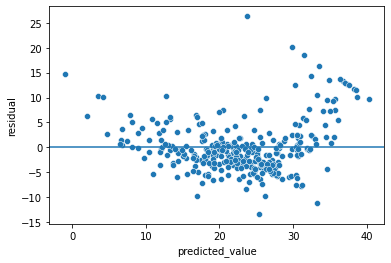

In [ ]:
# calculate residuals
residual = y_mdv_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

### Assumptions checked:
1. Linearity assumption validated
2. Residual didn't have a constant variance
3. Independent Risidual

## Training Error

In [ ]:
# prepare prediction result on training data
y_predict_train = lasso_best.predict(X_mdv_train)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_mdv_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_mdv_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_mdv_train, y_predict_train)))

RMSE for training data is 5.170346463296143
MAE for training data is 3.6858416211465084
MAPE for training data is 0.1749128202363825


## Testing Error

In [ ]:
# prepare prediction result on test data
X_mdv_test = feature_mdv_test.to_numpy()
y_predict_test = lasso_best.predict(X_mdv_test)

# ground truth target
y_mdv_test = target_mdv_test.to_numpy()
y_mdv_test = y_mdv_test.reshape(len(y_mdv_test),)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_mdv_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_mdv_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_mdv_test, y_predict_test)))

RMSE for testing data is 5.125494212319777
MAE for testing data is 3.3980507105960682
MAPE for testing data is 0.17856606338732206


Note : MAPE on training error = 0.1749 (17,49%) and MAPE on testing error = 0.1785 (17,86%); it shows that the model is just right, not overfitting or underfitting

By looking at the R2 Score, RMSE, MAE & MAPE ​​of the Ridge and Lasso, it's concluded that the Ridge matrix is ​​more optimal for modeling from the existing data.